<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/examplespline_computationgraphworking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)
img (32, 32)

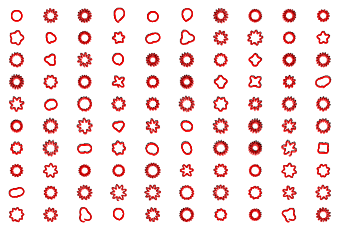

In [172]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 500
side = 32

global background
background = torch.zeros(2,side,side)
for i in range(side):
    for j in range(side):
        background[0,i,j] = j
        background[1,i,j] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    #print(x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)
    
    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,x[l,:].type(torch.LongTensor),y[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]
        points[l,:,1] = y[l,:]
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    
    #print(sample.shape)
    img = sample[0,:,:].squeeze().cpu().numpy()
    print('img',img.shape)
    #img = img[0,:,:]
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        model.eval()
        with torch.no_grad():
            global numpoints

            pred = model(sample.unsqueeze(0).cuda())
            print('predshape',pred.shape)
            predres = (int)(pred.shape[1]/2)
            X = pred[0,:predres]
            Y = pred[0,-predres:]
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[:numpoints,0]
        Y = labels[:numpoints,1]
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        #canvas = torch.from_numpy(canvas)
        #canvas = canvas.repeat(3, 1, 1).float()
        assert canvas.shape == (1,side,side)
        #bg = canvas[0,:,:]*background
        #canvas = torch.cat([canvas,background], dim = 0)
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:,:]
        #points = torch.from_numpy(points)
        assert points.shape == (numpoints,2)
        
        #return torch.flatten(canvas), points
        return canvas, points
    @staticmethod
    def displayCanvas(dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.plot(dpi=600)

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas(dataset, model = None)

In [171]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(5, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.sig = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        out = self._forward_impl(x)
        out = self.sig(out)*32.0
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet18(pretrained=False, progress=True, **kwargs):
    """ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    """ResNeXt-101 32x8d model from
    Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [2]:
x = [x for x in dataset]
print(len(x))
print(x[0][0].shape)
print(torch.flatten(x[0][0]).shape)
print(3*32*32)

100
torch.Size([3072])
torch.Size([3072])
3072


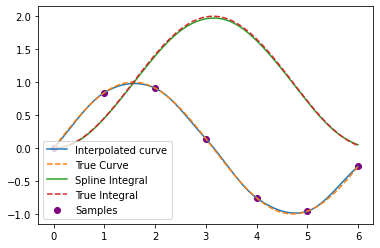

In [3]:
import matplotlib.pylab as P
import torch as T

def h_poly_helper(tt):
  A = T.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
  return [
    sum( A[i, j]*tt[j] for j in range(4) )
    for i in range(4) ]

def h_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = 1
  for i in range(1, 4):
    tt[i] = tt[i-1]*t
  return h_poly_helper(tt)

def H_poly(t):
  tt = [ None for _ in range(4) ]
  tt[0] = t
  for i in range(1, 4):
    tt[i] = tt[i-1]*t*i/(i+1)
  return h_poly_helper(tt)

def interp(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:], xs)
  dx = (x[I+1]-x[I])
  hh = h_poly((xs-x[I])/dx)
  return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx

def integ(x, y, xs):
  m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
  m = T.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
  I = P.searchsorted(x[1:], xs)
  Y = T.zeros_like(y)
  Y[1:] = (x[1:]-x[:-1])*(
      (y[:-1]+y[1:])/2 + (m[:-1] - m[1:])*(x[1:]-x[:-1])/12
      )
  Y = Y.cumsum(0)
  dx = (x[I+1]-x[I])
  hh = H_poly((xs-x[I])/dx)
  return Y[I] + dx*(
      hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx
      )

# Example
if __name__ == "__main__":
  x = T.linspace(0, 6, 7)
  y = x.sin()
  xs = T.linspace(0, 6, 101)
  ys = interp(x, y, xs)
  Ys = integ(x, y, xs)
  P.scatter(x, y, label='Samples', color='purple')
  P.plot(xs, ys, label='Interpolated curve')
  P.plot(xs, xs.sin(), '--', label='True Curve')
  P.plot(xs, Ys, label='Spline Integral')
  P.plot(xs, 1-xs.cos(), '--', label='True Integral')
  P.legend()
  P.show()


In [4]:
x = T.linspace(0,6,7)

In [5]:
y = x.sin()

In [6]:
xs = T.linspace(0, 6, 101)
ys = interp(x, y, xs)


In [7]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self,outclass = 101):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(101, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, outclass),
            nn.Tanh()
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


In [8]:
#print(xs.shape)
#a = torch.zeros(2,101)
#model(a).shape

In [9]:
model = MLP()
learning_rate = .0001
optimizer = T.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
for i in range(1000):
  output = model(xs.unsqueeze(0))
  loss = T.mean(T.abs(output-ys))
  #print('loss',loss)
  loss.backward()
  optimizer.step()

torch.Size([101])


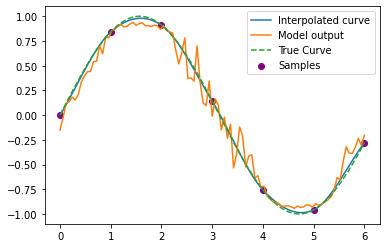

In [11]:
x = T.linspace(0, 6, 7)
y = x.sin()
xs = T.linspace(0, 6, 101)
out = model(xs.unsqueeze(0)).squeeze().detach()
print(xs.shape)
ys = interp(x, y, xs)
Ys = integ(x, y, xs)
P.scatter(x, y, label='Samples', color='purple')
P.plot(xs, ys, label='Interpolated curve')
P.plot(xs, out.numpy(), label='Model output')
P.plot(xs, xs.sin(), '--', label='True Curve')
P.legend()
P.show()


In [12]:
oc = 25
model = MLP(outclass=oc)
optimizer = T.optim.Adam(model.parameters(), lr=learning_rate)
x = T.linspace(0, 30, 25)
y = x.sin()
modelin = T.linspace(0, 30, 101)
xs = T.linspace(0, 30, 25)
xoc = T.linspace(0, 30, oc)

ys = interp(x, y, xs)
print(xoc.shape)

torch.Size([25])


In [13]:
for i in range(1000):
  output = model(modelin.unsqueeze(0)).squeeze()
  #print(output.shape)
  yout = interp(xoc,output,xs)
  loss = T.mean((yout-ys)**2)
  #print('loss',loss)
  loss.backward()
  optimizer.step()

torch.Size([101])


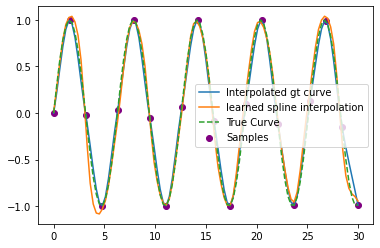

In [14]:
x = T.linspace(0, 30, 20)
y = x.sin()
xs = T.linspace(0, 30, 101)
out = model(xs.unsqueeze(0)).squeeze()
out = interp(xoc,output,xs).detach()
print(xs.shape)
ys = interp(x, y, xs)
Ys = integ(x, y, xs)
P.scatter(x, y, label='Samples', color='purple')
P.plot(xs, ys, label='Interpolated gt curve')
P.plot(xs, out.numpy(), label='learned spline interpolation')
P.plot(xs, xs.sin(), '--', label='True Curve')
P.legend()
P.show()


In [15]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self,outclass = 101):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, outclass),
            nn.Tanh()
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = self.layers(x)
        x=x*5.0
        return x


In [16]:
oc = 20
model = MLP(outclass=oc)
optimizer = T.optim.Adam(model.parameters(), lr=.00001)
x = T.linspace(0, 30, 25)
xs = T.linspace(0, 30, 100)
xoc = T.linspace(0, 30, oc)
print(xoc.shape)

torch.Size([20])


In [ ]:
for i in range(1000):
  c = [T.linspace(0, 30, 100) for x in range(16)]
  xin = T.cat(c).reshape(16,-1)
  yin = [ x.sin()*(.5+T.rand(1)) + 2.0*T.rand(1) for x in c]
  yin = T.cat(yin).reshape(16,-1)
  modelin = T.cat([xin, yin],dim=1)
  output = model(modelin).squeeze()
  print(xoc.shape, output.shape, xs.shape )
  inte = [interp(xoc,output[i,:],xs) for i in range(16)]
  inte = T.cat(inte)
  inte = inte.reshape(16,-1)
  #yout = interp(xoc,output,xs)
  yout = inte
  loss = T.mean((yout-yin.detach())**2)
  print('loss',loss)
  loss.backward()
  optimizer.step()

In [18]:
"""x = T.tensor([a for a in range(25)])
x = x.float()
x = T.cat([x,x])
x = x.reshape(2,-1)
y = T.tensor([a for a in range(25)])
y = y.float()
y = T.cat([y,y])
y = y.reshape(2,-1)
t = T.tensor([a for a in range(25)])
t = t.float()
t = T.cat([t,t])
t = t.reshape(2,-1)

print(x.shape,y.shape,t.shape)
#interp(x,y,t)
"""


'x = T.tensor([a for a in range(25)])\nx = x.float()\nx = T.cat([x,x])\nx = x.reshape(2,-1)\ny = T.tensor([a for a in range(25)])\ny = y.float()\ny = T.cat([y,y])\ny = y.reshape(2,-1)\nt = T.tensor([a for a in range(25)])\nt = t.float()\nt = T.cat([t,t])\nt = t.reshape(2,-1)\n\nprint(x.shape,y.shape,t.shape)\n#interp(x,y,t)\n'

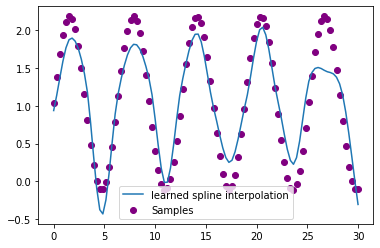

In [19]:
x = T.linspace(0, 30, 100)
modelin = T.linspace(0, 30, 100)
a = T.rand(1)
b = T.rand(1)
ys = modelin.sin()*(.5+a) + 2.0*b
modelin = T.cat([modelin, ys])
output = model(modelin.unsqueeze(0)).squeeze()
yout = interp(xoc,output,xs)
yout = yout.detach()
  
P.scatter(x, ys, label='Samples', color='purple')
P.plot(xs, yout.numpy(), label='learned spline interpolation')
P.legend()
P.show()

In [49]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self,outclass = 101):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(5120, 3000),
            nn.LeakyReLU(.2),
            nn.Linear(3000, 3000),
            nn.LeakyReLU(.2),
            nn.Linear(3000, 2000),
            nn.LeakyReLU(.2),
            nn.Linear(2000, outclass),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        #x = x.view(x.size(0), -1)
        x = self.layers(x)
        x = x*32.0
        return x


In [173]:
dataset_train = DonutDataset(4000)
dataset_val = DonutDataset(100)
print(dataset_train[0][0].shape)

torch.Size([1, 32, 32])


In [174]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self,outclass = 101):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(32**2, 32**2),
            nn.LeakyReLU(.2),
            nn.Linear(32**2, 32**2),
            nn.LeakyReLU(.2),
            nn.Linear(32**2, 32**2),
            nn.LeakyReLU(.2),
            nn.Linear(32**2, outclass),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        i = x.shape[0]
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        #x = x.view(x.size(0), -1)
        x = self.layers(x.reshape(i,-1))
        x = x*32.0
        return x


In [181]:
oc = 500
model = MLP(outclass=oc).cuda()
#model = resnet18().cuda()
#model = resnext101_32x8d().cuda()
optimizer = T.optim.Adam(model.parameters(), lr=.0001, weight_decay=.1)
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
    


In [182]:
from torch.utils import data
#criterion = CustomCriterion().cuda()
loader_train = data.DataLoader(
    dataset_train, batch_size=64,
    sampler=RandomSampler(data_source = dataset_train),
    num_workers=4)
loader_train = loader_train
model.train()
s = nn.Sigmoid()
for i in range(60):
  for x,y in loader_train:
    #print(x.shape)
    x = x.cuda()
    y = y.cuda()
    m = model(x)
    
    #m = s(m)*32.0
    m = m.reshape(-1,1000,2)
    loss = torch.mean((m-y)**2)
    loss.backward()
    optimizer.step()
    print(loss)

DonutDataset.displayCanvas(dataset_val,model)

RuntimeError: ignored

img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Size([1, 500])
img (32, 32)
predshape torch.Siz

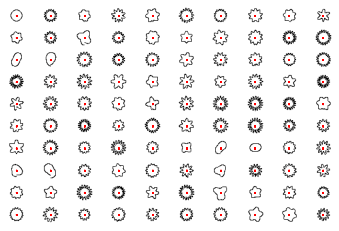

In [183]:
DonutDataset.displayCanvas(dataset_val,model)
